In [1]:
import torch
from datasets import load_dataset, DatasetDict
from peft import LoraConfig, get_peft_model
import evaluate
from transformers import DataCollatorForSeq2Seq, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

import matplotlib.pyplot as plt
from utils import prepare_prompt, print_trainable_parameters
import transformers
from tqdm import tqdm

import json




# Dataset Splitting

In [26]:
dataset_raw = load_dataset('json', data_files='dataset_llm_generated.json')
dataset = dataset_raw.select_columns(["text", "summary"])
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 5000
    })
})


Map:   0%|          | 0/4426 [00:00<?, ? examples/s]

Map:   0%|          | 0/4426 [00:00<?, ? examples/s]

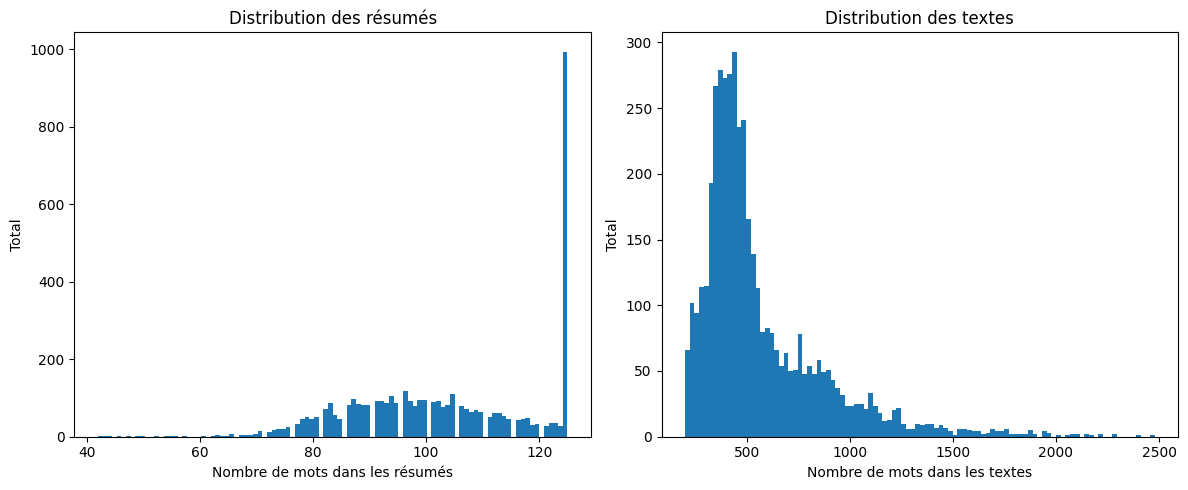

In [30]:
def get_num_word_summary(example):
    return {"num_word_summary": len(example["summary"].split())}
def get_num_word_text(example):
    return {"num_word_text": len(example["text"].split())}

dataset_num_word = dataset['train'].map(get_num_word_summary)
dataset_num_word = dataset_num_word.map(get_num_word_text)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(dataset_num_word["num_word_summary"], bins=100)
axes[0].set_xlabel("Number of words in summaries")
axes[0].set_ylabel("Total")
axes[0].set_title("Distribution of summaries")

axes[1].hist(dataset_num_word["num_word_text"], bins=100)
axes[1].set_xlabel("Number of words in texts")
axes[1].set_ylabel("Total")
axes[1].set_title("Distribution of texts")


plt.tight_layout()  
plt.show()

In [31]:
dataset['train'] = dataset['train'].filter(lambda x: len(x['text'].split()) <= 2500)
dataset['train'] = dataset['train'].filter(lambda x: len(x['text'].split()) >= 200)
dataset['train'] = dataset['train'].filter(lambda x: len(x['summary'].split()) >= 40)

print(dataset)

Filter:   0%|          | 0/4426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4426 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 4426
    })
})


In [7]:
split_train_temp = dataset["train"].train_test_split(test_size=0.4, seed=42)

split_valid_test = split_train_temp["test"].train_test_split(test_size=0.5, seed=42)

dataset_split = DatasetDict({
    "train": split_train_temp["train"],        
    "validation": split_valid_test["train"],      
    "test": split_valid_test["test"]              
})

print(dataset_split)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['text', 'summary'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 1000
    })
})


# Model Fine-Tuning

In [5]:
slm_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer_slm = AutoTokenizer.from_pretrained(slm_name, cache_dir="/Data/gabriel-mercier/slm_models", padding_side="left")
tokenizer_slm.pad_token = tokenizer_slm.eos_token

In [8]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True, 
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_quant_type='nf4',
                            )
model_raw = AutoModelForCausalLM.from_pretrained(
    slm_name,
    cache_dir="/Data/gabriel-mercier/slm_models",
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map="auto"   
)


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [10]:
#lora_alpha = 2 * rank

lora_finetune = True

if lora_finetune:
    lora_config = LoraConfig(r=16, 
                            lora_alpha=32,
                            target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
                            lora_dropout=0.05,
                            bias='none',
                            task_type="CAUSAL_LM")

    model = get_peft_model(model_raw, lora_config)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



In [12]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer_slm.eos_token_id
generation_config.eos_token_id = tokenizer_slm.eos_token_id
generation_config.do_sample = True

print_trainable_parameters(model)

trainable params: 2162688 || all params: 317282176 || trainable%: 0.6816292132338376


### Example

In [20]:
assistant_start = "Résumé concis et structuré (100 mots maximum) :"
summary_data = dataset_split['train'][1]['summary']
prompt = prepare_prompt(dataset_split['train'][1], summary_included=False)

encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)

with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
prediction = tokenizer_slm.decode(outputs[0], skip_special_tokens=True)

start_index = prediction.find(assistant_start)
if start_index != -1:
    response_start = start_index + len(assistant_start)
else:
    response_start = -1 

print("=== GENERATED SUMMARY ===")
print(prediction[response_start+1:])
print(len(prediction[response_start+1:].split()))

print("=== LABEL SUMMARY ===")
print(summary_data)
print(len(summary_data.split()))

=== GENERATED SUMMARY ===
Troy Davis, condamné à mort pour le meurtre d'un policier blanc en 1989, est présenté par de nombreux personnalités comme le prototype du Noir innocent. Il est condamné à mort par injection létale. Le comité des grâces de Géorgie appelle à la pardon de la peine. Plus de 663 000 signatures sont demandées pour la pétition. Les manifestants s'expriment contre la peine de mort. Troy Davis, âgé de 42 ans, est présenté par des personnalités comme Jimmy Carter, le Pape Benoît XVI ou l'actrice Susan Sarandon. L'avocat de Davis a annoncé que la nouvelle audience serait possible avec la permission du juge. Des témoins ont confirmé des déclarations contradictoires. Le verdict final reste attendu. Le processus continue.
117
=== LABEL SUMMARY ===
Troy Davis, condamné à mort pour le meurtre d'un policier en 1989, doit être exécuté malgré des doutes sur sa culpabilité. Des manifestations mondiales réclament sa clémence. Le sort de Davis, 42 ans, est entre les mains du comité

In [14]:
def generate_and_tokenize_prompt(data_point):
    full_prompt = prepare_prompt(data_point)+tokenizer_slm.eos_token 
    tokenized_full_prompt = tokenizer_slm(full_prompt, return_tensors='pt')
    labels = tokenized_full_prompt.input_ids.clone() 
    
    assistant_token = tokenizer_slm("Résumé concis et structuré", return_tensors='pt')['input_ids'][0]
   
    complement_token = tokenizer_slm("(100 mots maximum) :", return_tensors='pt')['input_ids'][0]
    
    T = tokenized_full_prompt['input_ids'].flatten()
    S = assistant_token.flatten()
    
    for i in range(len(T) - len(S) + 1):
        if torch.equal(T[i:i+len(S)], S):
            end_prompt_idx = i+len(S)   
    
    labels[:, :end_prompt_idx+len(complement_token)] = -100
    

    return {
        'input_ids': tokenized_full_prompt.input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': tokenized_full_prompt.attention_mask.flatten(),
    }


In [15]:
dataset_train = dataset_split["train"].shuffle(seed=42).map(generate_and_tokenize_prompt)
dataset_val = dataset_split["validation"].shuffle(seed=42).map(generate_and_tokenize_prompt)

dataset_train = dataset_train.remove_columns(["text", "summary"])
dataset_val = dataset_val.remove_columns(["text", "summary"])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:
print(dataset_train)
print(dataset_val)

Dataset({
    features: ['input_ids', 'labels', 'attention_mask'],
    num_rows: 3000
})
Dataset({
    features: ['input_ids', 'labels', 'attention_mask'],
    num_rows: 1000
})


### Training

In [23]:
training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=3,
    logging_steps=2,
    output_dir="./qwen_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
)


/users/eleves-b/2022/gabriel.mercier/INF_CV/myenv/lib64/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer_slm, model=model),
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.116600,1.340596


TrainOutput(global_step=1442, training_loss=1.3544280456273137, metrics={'train_runtime': 1136.7484, 'train_samples_per_second': 5.079, 'train_steps_per_second': 1.269, 'total_flos': 1.3843660845696e+16, 'train_loss': 1.3544280456273137, 'epoch': 1.9975753377208174})

In [26]:
trainer.save_model("./autoregressive_model")

# Model Evaluation

In [18]:
model = AutoModelForCausalLM.from_pretrained("./autoregressive_model")
model.to(device)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=896, out_features=896, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=896, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=896, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=896, out_features=128, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropou

### Example

In [22]:
encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
prediction = tokenizer_slm.decode(outputs[0], skip_special_tokens=True)

start_index = prediction.find(assistant_start)
if start_index != -1:
    response_start = start_index + len(assistant_start)
else:
    response_start = -1 


print("=== GENERATED SUMMARY ===")
print(prediction[response_start+1:])
print(len(prediction[response_start+1:].split()))
print("=== LABEL SUMMARY ===")
print(summary_data)
print(len(summary_data.split()))

=== GENERATED SUMMARY ===
Troy Davis, condamné à mort pour le meurtre d'un policier blanc en 1989, est présenté par des figures comme le prototype du Noir innocent. Les rassemblements pour son exécution s'estiment nombreux à travers le monde, avec des manifestances en France et en Amérique latine. Le comité des grâces de Géorgie s'inquiète de sa culpabilité. La France exprime son préoccupations face à l'affaire. Des témoins disent avoir trouvé des détails contradictoires sur la source des informations sur le tueur. L'enquête continue sur l'arme utilisée. Le verdict final sera établi en 2020. Les tensions autour de la peine de mort persistent.
99
=== LABEL SUMMARY ===
Troy Davis, condamné à mort pour le meurtre d'un policier en 1989, doit être exécuté malgré des doutes sur sa culpabilité. Des manifestations mondiales réclament sa clémence. Le sort de Davis, 42 ans, est entre les mains du comité des grâces de Géorgie. Neuf témoins initialement l'avaient identifié comme l'auteur du coup d

In [1]:
dataset_test = dataset_split['test']

NameError: name 'dataset_split' is not defined

In [23]:
rouge = evaluate.load("rouge")
bert_score = evaluate.load("bertscore")


In [36]:
def evaluate_model(model, dataset):
    summaries = [data_point['summary'] for data_point in dataset]
    predictions = []

    for data_point in tqdm(dataset):
        prompt = prepare_prompt(data_point, summary_included=False)
        encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
        with torch.inference_mode():
            output = model.generate(
                input_ids=encoding.input_ids,
                attention_mask=encoding.attention_mask,
                generation_config=generation_config,
            )
            
        prediction = tokenizer_slm.decode(output[0], skip_special_tokens=True)
        response_start = prediction.find(assistant_start)
        # print(f"response start {response_start}")
        predictions.append(prediction[response_start:])
    # print(f"predictions {predictions}")
    rouge_results = rouge.compute(predictions=predictions, references=summaries)
    bert_results = bert_score.compute(predictions=predictions, references=summaries, lang="fr")

    # Moyenne des scores sur toutes les phrases
    bert_precision = np.mean(bert_results['precision'])
    bert_recall = np.mean(bert_results['recall'])
    bert_f1 = np.mean(bert_results['f1'])

    print(f"BERTScore - Precision: {bert_precision:.4f}, Recall: {bert_recall:.4f}, F1: {bert_f1:.4f}")
    print(f"ROUGEScores - {rouge_results}")
    print('\n')
    
    return rouge_results, {'Precision':bert_precision, 'Recall':bert_recall, 'F1':bert_f1}


In [40]:
rouges_results_finetune, bert_results_finetune = evaluate_model(model, dataset_split)

100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

set = test : ROUGE Scores: {'rouge1': np.float64(0.464979937080518), 'rouge2': np.float64(0.18933791587433021), 'rougeL': np.float64(0.26111108779528147), 'rougeLsum': np.float64(0.26111108779528147)} BERTScore: {'precision': [0.7415640950202942, 0.7421576976776123, 0.8008397817611694, 0.7783476114273071, 0.7884026169776917], 'recall': [0.7208572626113892, 0.7379992604255676, 0.8021383285522461, 0.7677578330039978, 0.7191553711891174], 'f1': [0.7310640811920166, 0.7400726675987244, 0.8014885187149048, 0.7730164527893066, 0.7521886229515076], 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.49.0)'}


In [41]:
results_finetune = {
    "rouge": rouges_results_finetune,
    "bert": bert_results_finetune
}

with open("evaluation_results_finetune.json", "w") as f:
    json.dump(results_finetune, f, indent=4)


In [42]:
model_raw = AutoModelForCausalLM.from_pretrained(
    slm_name,
    cache_dir="/Data/gabriel-mercier/slm_models",
)
model_raw.to(device)


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [43]:
rouges_results_raw, bert_results_raw = evaluate_model(model_raw, dataset_split)

results_raw = {
    "rouge": rouges_results_raw,
    "bert": bert_results_raw
}

with open("evaluation_results_raw.json", "w") as f:
    json.dump(results_raw, f, indent=4)

100%|██████████| 5/5 [00:25<00:00,  5.06s/it]


set = test : ROUGE Scores: {'rouge1': np.float64(0.4239170234979143), 'rouge2': np.float64(0.1426617463543708), 'rougeL': np.float64(0.22357244307986474), 'rougeLsum': np.float64(0.24112311942212616)} BERTScore: {'precision': [0.709868311882019, 0.723460853099823, 0.6941249370574951, 0.7389551401138306, 0.7530248165130615], 'recall': [0.7581321001052856, 0.7192240357398987, 0.7142411470413208, 0.75519859790802, 0.7509481906890869], 'f1': [0.7332068681716919, 0.7213361859321594, 0.7040393948554993, 0.7469885945320129, 0.7519850730895996], 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.49.0)'}
